The notebook will generate a two-dimensional bathymetry along the thalweg for simulation runs.

Two-dimensional simulations will allow us to quickly experiment with changes in resolution, mxing parameters etc

NEMO 3.6 is expecting obcs t start on a land/oean corner. This notebook will masked all of the edges.

# Load model thalweg

In [1]:
import netCDF4 as nc
import numpy as np
from salishsea_tools import tidetools, nc_tools
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
grid=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy,X,Y=tidetools.get_bathy_data(grid)

lines = np.loadtxt(
        '/data/nsoontie/MEOPAR/tools/bathymetry/thalweg_working.txt',
        delimiter=" ", unpack=False)
lines = lines.astype(int)


lines.shape

(1539, 2)

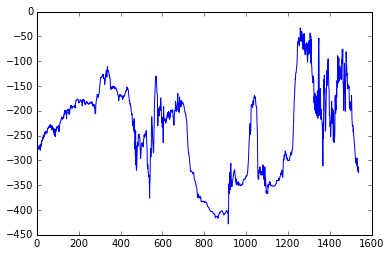

In [3]:
plt.plot(-bathy[lines[:,0],lines[:,1]])

To do:
1. Exclude northern SoG and Johnstone Strait
2. Close the right most boundary.
3. Smooth (make SoG more like a basin?)
4. Set a spatial scale (easiest to set a 500 m grid spacing between points)
5. Extend into y by 10 gridpoints

# 1. Exclude north

Exlcude the north by setting a cuttoff value.

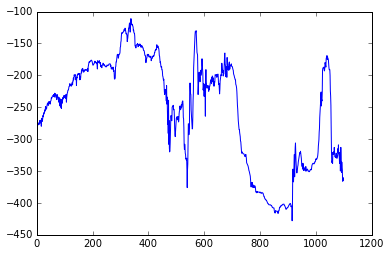

In [4]:
ie=1100

thalweg_nonorth=-bathy[lines[0:ie,0],lines[0:ie,1]]
plt.plot(thalweg_nonorth)

Look for the index of the peak at the right:

In [5]:
imax=np.argmax(thalweg_nonorth[1000:ie])
thalweg_nonorth[1000:ie][imax]


-169.0

In [6]:
ind=np.where(thalweg_nonorth==thalweg_nonorth[1000:ie][imax])
ind

(array([ 388,  389,  418,  420,  439, 1040]),)

In [7]:
indp = ind[0][-1]
indp

1040

# 2. Close right boundary

After the peak, extend to surface. Just use a line for now...

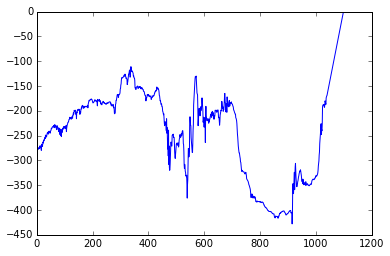

In [8]:
slope = (0-thalweg_nonorth[indp])/(len(thalweg_nonorth)-1-indp)
thalweg_right=thalweg_nonorth.copy()
thalweg_right[indp:] = (np.arange(indp,len(thalweg_nonorth))-(len(thalweg_nonorth)-1))*slope
plt.plot(thalweg_right)

In [9]:
thalweg_right[-1]

0.0

# 3. Smooth

Smoothing from signal processing. Convolve with a window function. Try a common functions and check result

In [10]:
def smooth(x,window_len,window):
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
         w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    y= y[(window_len/2-1):-(window_len/2)]

    return y

(1100,)
(1100,)
(1100,)
(1100,)
(1100,)


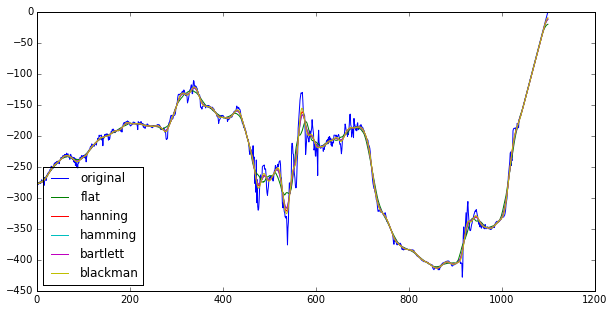

In [11]:
fig=plt.figure(figsize=(10,5))
w_len=30
windows=['flat','hanning','hamming', 'bartlett','blackman']
plt.plot(thalweg_right,label='original')
for w in windows:
    y=smooth(thalweg_right,w_len,w)
    print y.shape
    plt.plot(y,label=w)

plt.legend(loc=0)

Many featurs remain present (like the SoG basin). The large peak around 600 is much smaller ...

Use blackman because it keeps the beak the highest and extends closes to surface at right.

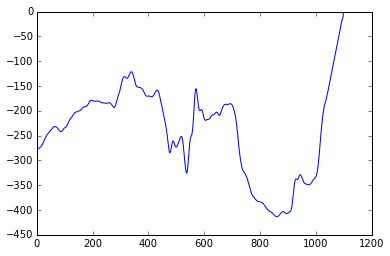

In [12]:
w_len=30
y=smooth(thalweg_right,w_len,'blackman')
y[-1]=0;#keep right end closed
thalweg_smooth=y
plt.plot(thalweg_smooth,label='smoothed')

In [13]:
y[-1]

0.0

# 4. Spatial scale

Set hoizontal grid spacing to 500m.

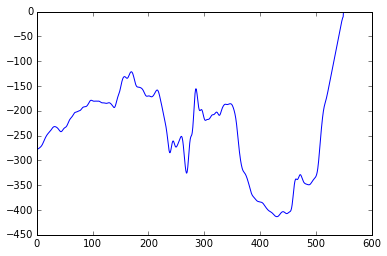

In [14]:
dx=500
# x is variable for horiztonal space
x=dx*np.linspace(0,thalweg_smooth.shape[0]-1,thalweg_smooth.shape[0]);

plt.plot(x/1000,thalweg_smooth)


# 5. Extend into y

In [15]:
Ny=10; dy=500
y = dy*np.linspace(0,Ny-1,Ny)

thalweg_y=np.tile(thalweg_smooth,Ny)
thalweg_y=thalweg_y.reshape((y.shape[0],thalweg_smooth.shape[0]))
thalweg_y.shape


(10, 1100)

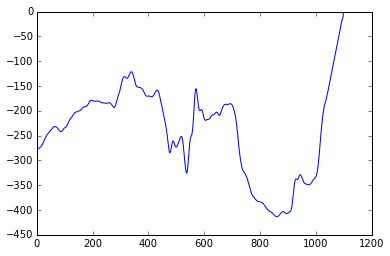

In [16]:
plt.plot(thalweg_y[0,:])

In [17]:
xx,yy=np.meshgrid(x,y)
xx.shape

(10, 1100)

<matplotlib.colorbar.Colorbar instance at 0x7f34e63104d0>

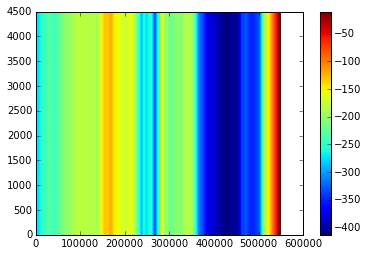

In [18]:
plt.pcolormesh(xx,yy,thalweg_y)
plt.colorbar()

# Mask edges

In [19]:
thalweg_mask = thalweg_y

thalweg_mask[0:2,:]=0
thalweg_mask[-2:,:]=0
thalweg_mask[:,0:2]=0
thalweg_mask[:,-2:]=0

[0, 10, 0, 10]

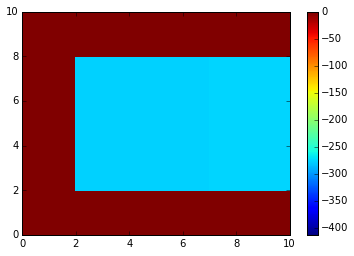

In [22]:
plt.pcolormesh(thalweg_mask)
plt.colorbar()
plt.axis([0,10,0,10])

# Finalize and Create Netcdf file

In [23]:
thalweg_final=-thalweg_mask #positive bathy values for saving

new_bathy = nc.Dataset('../bathy2D_36.nc', 'w')
new_bathy.createDimension('y', thalweg_final.shape[0])
new_bathy.createDimension('x', thalweg_final.shape[1])
nc_tools.show_dimensions(new_bathy)

<type 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 10

<type 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1100



In [24]:
new_x = new_bathy.createVariable('x', float, ('y', 'x'), zlib=True)
new_x.setncattr('units', 'metres')
new_y = new_bathy.createVariable('y', float, ('y', 'x'), zlib=True)
new_y.setncattr('units', 'metres')
newdepths = new_bathy.createVariable(
    'Bathymetry', float, ('y', 'x'), 
    zlib=True, least_significant_digit=1)
newdepths.setncattr('units', 'metres')

In [25]:
new_x[:]=xx;
new_y[:]=yy;
newdepths[:]=thalweg_final

In [26]:
new_bathy.title="""Thalweg Bathymetry for 2D model NEMO 3.6"""
new_bathy.institution= """ 
Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia"""
new_bathy.comment= """
Based on bathy_meter_SalishSea2.nc along thalweg with smoothing"""
new_bathy.reference= """
/data/nsoontie/MEOPAR/2Ddomain/notebooks/Generate_2D_bathy.ipynb"""

In [27]:
nc_tools.show_dataset_attrs(new_bathy)


file format: NETCDF4
title: Thalweg Bathymetry for 2D model NEMO 3.6
institution:  
Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
comment: 
Based on bathy_meter_SalishSea2.nc along thalweg with smoothing
reference: 
/data/nsoontie/MEOPAR/2Ddomain/notebooks/Generate_2D_bathy.ipynb


In [28]:
new_bathy.close()

<matplotlib.colorbar.Colorbar instance at 0x7f34e5418200>

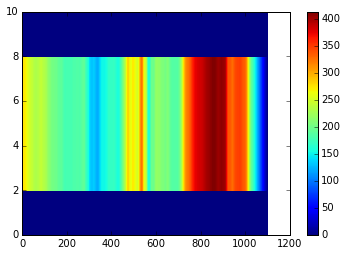

In [29]:
B=nc.Dataset('../bathy2D_36.nc')
thal=B.variables['Bathymetry']
plt.pcolormesh(thal[:]); plt.colorbar()

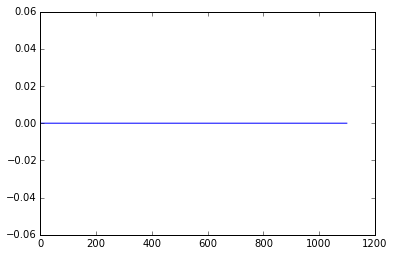

In [30]:
plt.plot(-thal[1,:])

In [31]:
thal[0,-1]

-0.0

Looks good enough to me.

# Next Steps

1. Create z grid
2. Generate initial conditions
3. Generate forcings
4. Look into coordinates defined in metres, not lon/lat (jphgr_mesh=2, set ppe1_m,ppe2_m). Also consider looking at GYRE configuration. 
4. Run?

# Ideas and questions


* Adjust bottom roughness coefficent
* Different horizontal and vertical resolutions
* Different mixing parametrizations (TKE, k-e)
* Different treatments for diffusivity and viscosity